## Necessary dependencies

In [81]:
import subprocess
import sys

# List of required dependencies (external packages only)
dependencies = ["torch", "torchvision", "Pillow", "opencv-python", "numpy", "scikit-image", "scipy", "scikit-learn"]

print("Installation of dependencies...")
for package in dependencies:
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("✓ All dependencies are installed !")

Installation of dependencies...
✓ All dependencies are installed !


## Importing functions

In [103]:
import importlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# Add the project root folder to the path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

import config
from unet_model import model, dataset, train, test

# Reload
importlib.reload(config)
importlib.reload(model)
importlib.reload(dataset)
importlib.reload(train)
importlib.reload(test)

from config import DATASET_NORMALIZER_DIR, UNET_MODEL_DIR, SAVED_MODELS_DIR, UNet_BUSI_benign, UNet_BUSI_malignant, UNet_ISBI
from unet_model.dataset import dataset_ds
from unet_model.train import train_model_paper, train_model_study
from unet_model.test import test_model

print("✓ All dependencies are imported !")

✓ All dependencies are imported !


# --- I. Paper version ---

## 1. Model's training

In [104]:
model_dir = SAVED_MODELS_DIR
model_save = UNet_ISBI
root_dir = r"D:\Documents #\5e Année\MLA\bdd\_normalized\ISBI"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
 
train_ds, _, test_ds = dataset_ds(root_dir)
model, train_losses = train_model_paper(model_dir, model_save, train_ds, device)

Using device: cuda
Starting training...

Epoch 1/1000
  Train Loss: 0.6456
Epoch 2/1000
  Train Loss: 0.6386
Epoch 3/1000
  Train Loss: 0.5983
Epoch 4/1000
  Train Loss: 0.5918
Epoch 5/1000
  Train Loss: 0.5625
Epoch 6/1000
  Train Loss: 0.5830
Epoch 7/1000
  Train Loss: 0.5780
Epoch 8/1000
  Train Loss: 0.5764
Epoch 9/1000
  Train Loss: 0.5619
Epoch 10/1000
  Train Loss: 0.5808
Epoch 11/1000
  Train Loss: 0.5766
Epoch 12/1000
  Train Loss: 0.5761
Epoch 13/1000
  Train Loss: 0.5709
Epoch 14/1000
  Train Loss: 0.5688
Epoch 15/1000
  Train Loss: 0.5778
Epoch 16/1000
  Train Loss: 0.5667
Epoch 17/1000
  Train Loss: 0.5676
Epoch 18/1000
  Train Loss: 0.5730
Epoch 19/1000
  Train Loss: 0.5717
Epoch 20/1000
  Train Loss: 0.5593
Epoch 21/1000
  Train Loss: 0.5629
Epoch 22/1000
  Train Loss: 0.5743
Epoch 23/1000
  Train Loss: 0.5671
Epoch 24/1000
  Train Loss: 0.5843
Epoch 25/1000
  Train Loss: 0.5695
Epoch 26/1000
  Train Loss: 0.5663
Epoch 27/1000
  Train Loss: 0.5770
Epoch 28/1000
  Train L

## 2. Visualizing the evolution of the model's training

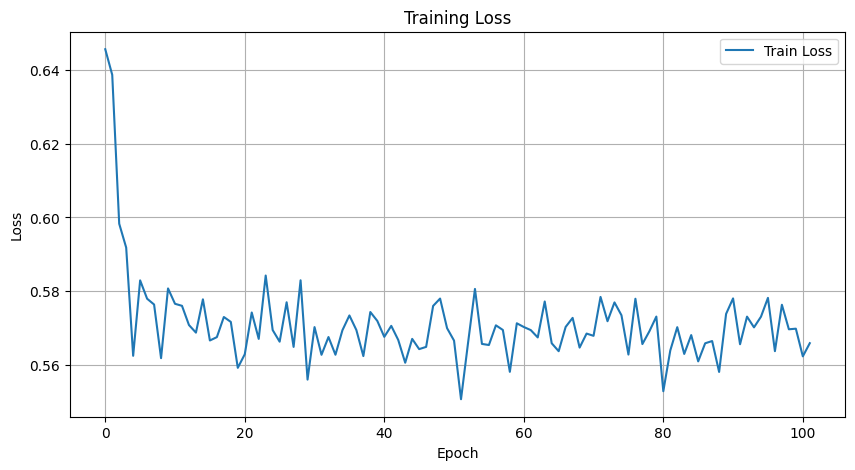

In [105]:
def plot_training_curves(train_losses):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Get some sample images and masks from the test set
plot_training_curves(train_losses)

## 3. Visualizing the result of testing


Model loaded. Starting evaluation...



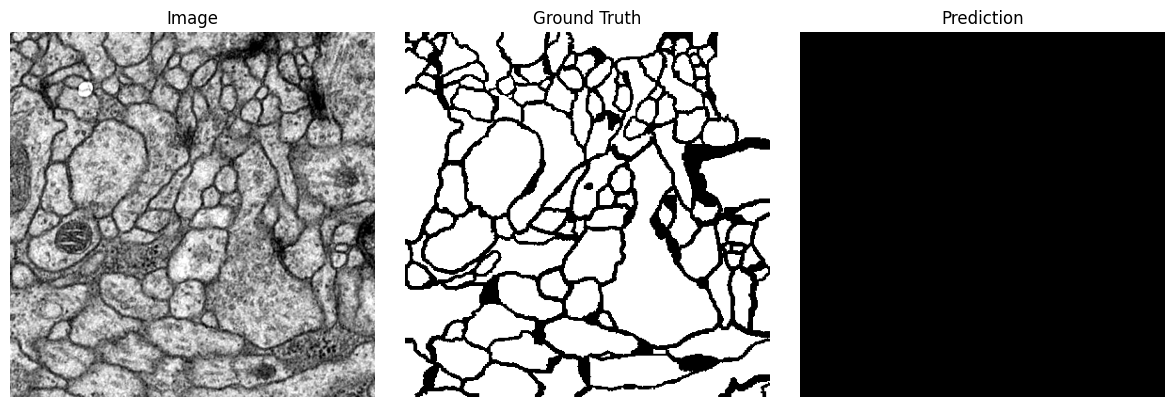

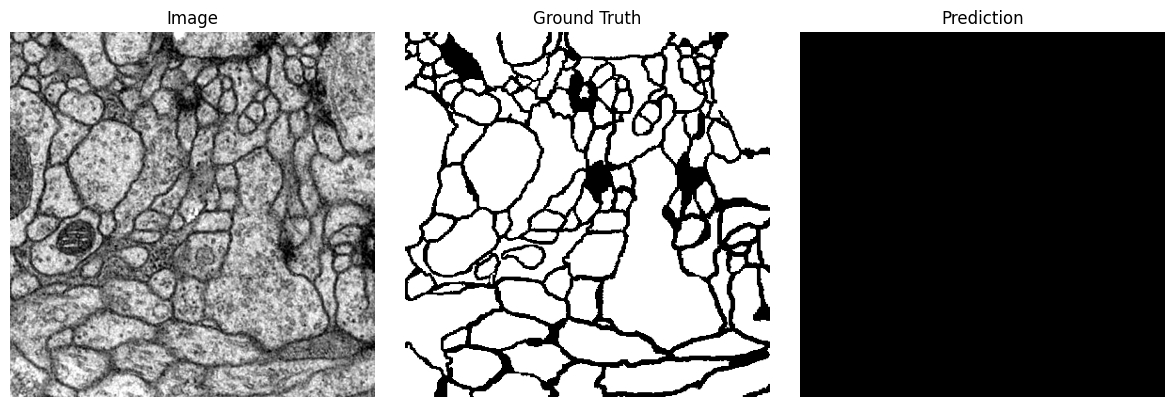

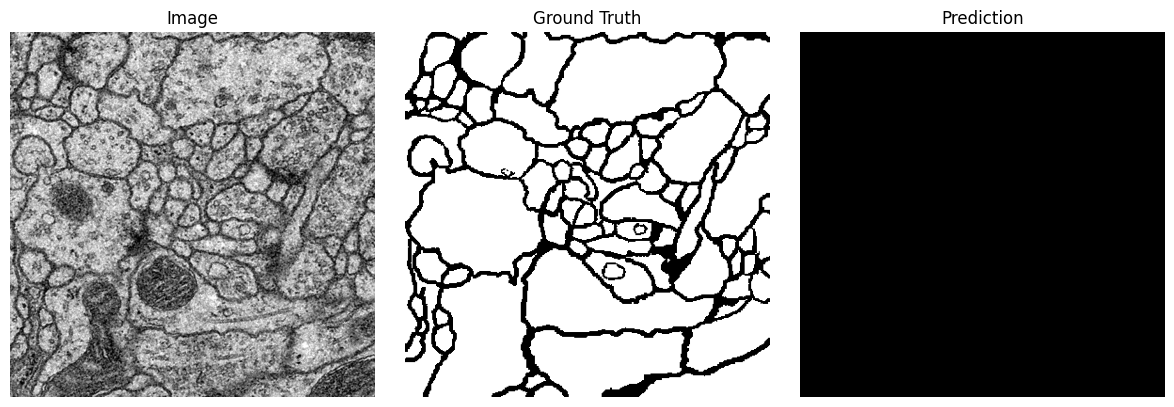


======= TEST RESULTS =======
Warping Error: 1.0000
Rand Error:    1.0000
Pixel Error:   0.2287
IoU Score:     0.7713


In [106]:
model_dir = SAVED_MODELS_DIR
model_save = UNet_ISBI
# Evaluate on test set
mean_warp, mean_rand, mean_pix, mean_iou = test_model(model_dir, model_save, test_ds, device)

# --- II. Study version ---

## 1. Model's training

In [107]:
# Order of hyperparameters : epochs, learning_rate, momentum, dropout_rate, batch_size
hyperparams = ([50, 100], [0.01, 0.001], [0.9, 0.99], [0.2, 0.35, 0.5], [2, 4])

model_dir = SAVED_MODELS_DIR
model_save = UNet_ISBI
root_dir = r"D:\Documents #\5e Année\MLA\bdd\_normalized\ISBI"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
 
train_ds, val_ds, test_ds = dataset_ds(root_dir)
# Create subsets for hyperparameter study with K-Fold Cross Validation
train_subset, val_subset = """
To be continued
"""

pass
model, train_losses, val_losses = train_model_study(model_dir, model_save, train_subset, val_subset, hyperparams)

Using device: cuda


ValueError: too many values to unpack (expected 2)

## 2. Visualizing the evolution of the model's training

In [108]:
def plot_training_curves(train_losses, val_losses):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Get some sample images and masks from the test set
plot_training_curves(train_losses, val_losses)

NameError: name 'val_losses' is not defined

## 3. Visualizing the result of testing

In [109]:
model_dir = SAVED_MODELS_DIR
model_save_tot = "50_0.01_0.9_0.2_2_unet_isbi.pth"
# Evaluate on test set
mean_warp, mean_rand, mean_pix, mean_iou = test_model(model_dir, model_save_tot, test_ds, device)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Documents #\\5e Année\\MLA\\Projet\\saved_models\\50_0.01_0.9_0.2_2_unet_isbi.pth'